---
# Imports, Constants and Paths

In [ ]:
from pathlib import Path
import os
import sys
import json
import subprocess
import shutil
from typing import Optional, List, Tuple, Dict # This is just for type hinting. Doesn't affect the code at all.

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import moviepy
from moviepy.editor import VideoFileClip, concatenate_videoclips
from dataclasses import dataclass

# There is a conflict between moviepy and the current version of PIL.
# !pip uninstall pillow
# !pip install pillow==9.5.0

import PIL

In [2]:
print(f'Moviepy version: {moviepy.__version__}')
print(f'Pillow version: {PIL.__version__}')

Moviepy version: 1.0.3
Pillow version: 9.5.0


In [3]:
Path.cwd()

WindowsPath('c:/Proyectos/George Brown Projects/2 Semester/Full Stack/AI Travel Video Summarizer/Notebooks')

### Important Paths:

In [4]:
PATH_VIDS = Path(r"../data/Videos") # Relative path where the videos are stored.
PATH_OUTPUT = Path(r"../data/Output") # Relative path where the concatenated videos are stored.
PATH_CONVERTED = Path(r"../data/Converted") # Relative path where the converted videos are stored.

print(f"- Path Vids Dir: {PATH_VIDS}")
print(f"- Path Output Dir: {PATH_OUTPUT}")

- Path Vids Dir: ..\data\Videos
- Path Output Dir: ..\data\Output


### Gloval Constants:

In [5]:
FORMATS = [".mp4", ".avi", ".mkv", ".mov"]

# type of video resolution:
LANDSCAPE_RESOLUTION = (1280, 720)
REEL_RESOLUTION = (720, 1280)
TARGET_RESOLUTION = REEL_RESOLUTION # Current working resolution.

# For clip lenght:
MIN_CLIP_LENGTH = 2
MAX_CLIP_LENGTH = 10
MAX_TOTAL_LENGTH = 60

---
# Preliminary Function

In [ ]:
""" This function checks which videos are available in the videos data folder. """
def available_vids(folder : Path) -> list:
    return [v for v in folder.iterdir() if v.is_file() and v.suffix in FORMATS]

available_vids(PATH_VIDS)

[WindowsPath('../data/Videos/20250803_210032.mp4'),
 WindowsPath('../data/Videos/VID-20231015-WA0004.mp4'),
 WindowsPath('../data/Videos/VID-20231018-WA0010.mp4'),
 WindowsPath('../data/Videos/VID-20240520-WA0021.mp4'),
 WindowsPath('../data/Videos/VID-20241219-WA0016.mp4'),
 WindowsPath('../data/Videos/VID-20250603-WA0008.mp4'),
 WindowsPath('../data/Videos/VID-20250628-WA0001.mp4'),
 WindowsPath('../data/Videos/VID-20250711-WA0040.mp4'),
 WindowsPath('../data/Videos/VID-20250912-WA0024.mp4'),
 WindowsPath('../data/Videos/VID-20251015-WA0030.mp4'),
 WindowsPath('../data/Videos/VID_20230830_155323.mp4'),
 WindowsPath('../data/Videos/VID_244570202_224434_526.mp4'),
 WindowsPath('../data/Videos/VID_277990505_144226_118.mp4'),
 WindowsPath('../data/Videos/VID_297810421_134556_231.mp4')]

---
# Video Convertion

#### Get videos information:

In [7]:
""" This function uses ffprobe to get video info. Requires ffmpeg/ffprobe to be installed and in the PATH. """
def ffprobe_get_video_info(video_path: Path) -> Optional[dict]:
    cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries",
    "stream=codec_name,avg_frame_rate,r_frame_rate,nb_frames,duration",
        "-of", "json",
        str(video_path)
    ]
    try:
        result = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True
        )
        data = json.loads(result.stdout)
        streams = data.get("streams", [])
        if not streams:
            return None
        return streams[0]
    except subprocess.CalledProcessError as e:
        print(f"[ffprobe] Error when getting video info for {video_path.name}: {e}")
        return None

#### Find problematic videos. Detects if the video is HEVC or VFR:

In [8]:
""" This function checks if the video codec is HEVC/H.265. """
def is_hevc(stream_info: Dict) -> bool:
    codec = stream_info.get("codec_name", "").lower()
    return codec in {"hevc", "h265"} # Depending on the tools/containers, the codec name can be either "hevc" or "h265".

#-------------------------------------------------------------------------------

""" This function returns the frame rate of the video. """
def _parse_fps_rate(fps_str: str) -> Optional[float]:
    """
    Convierte '30000/1001' → float.
    Devuelve None si no se puede parsear.
    """
    if not fps_str or fps_str == "0/0":
        return None
    if "/" in fps_str:
        num, den = fps_str.split("/")
        try:
            return float(num) / float(den)
        except ZeroDivisionError:
            return None
    try:
        return float(fps_str)
    except ValueError:
        return None
    
#-------------------------------------------------------------------------------

""" This function checks if it looks like the video is VFR type (Variable Frame Rate). """
def is_vfr(stream_info: Dict, tol: float = 0.01) -> bool:
    """
    True si parece ser Variable Frame Rate.
    Heurística: comparamos avg_frame_rate vs r_frame_rate.
    Si difieren más de 'tol', lo tomamos como VFR.
    """
    avg_str = stream_info.get("avg_frame_rate", "")
    r_str = stream_info.get("r_frame_rate", "")

    avg = _parse_fps_rate(avg_str)
    r = _parse_fps_rate(r_str)

    if avg is None or r is None:
        # Si no podemos decidir, asumimos que NO es VFR
        return False

    return abs(avg - r) > tol

#-------------------------------------------------------------------------------

""" This functino decides if the video should be converted (if it is HEVC or VFR). """
def needs_conversion(stream_info: Dict) -> bool:
    return is_hevc(stream_info) or is_vfr(stream_info)

#### Just convert the problematic videos:

In [9]:
def convert_video_to_h264(input_path: Path, 
                          output_path: Path, 
                          target_fps: int = 30) -> None:
    """
    Convierte un video a H.264 + AAC, fps constante.
    No sobreescribe si el archivo de salida ya existe.
    """
    if output_path.exists():
        print(f"  [SKIP] Ya existe: {output_path.name}")
        return

    cmd = [
        "ffmpeg",
        "-y",                # overwrites without asking.
        "-i", str(input_path),
        "-c:v", "libx264",
        "-preset", "fast",
        "-crf", "18",        # calidad visual alta (puedes subir a 20–23 si quieres archivos más ligeros)
        "-pix_fmt", "yuv420p",
        "-r", str(target_fps),
        "-c:a", "aac",
        "-movflags", "+faststart",
        str(output_path)
    ]

    print(f"  [ffmpeg] Converting: {input_path.name} → {output_path.name}")
    try:
        subprocess.run(cmd, check=True)
        print(f"  [OK] {output_path.name} converted\n")
    except subprocess.CalledProcessError as e:
        print(f"  [ERROR] Conversion fail {input_path.name}: {e}\n")


#### Main function for video conversion:

In [10]:
def convert_input_videos(input_dir: Path, 
                         output_dir: Path,
                         target_fps: int = 30) -> None:
    """
    Recorre los videos en input_dir (usando available_vids),
    detecta códec y VFR, y convierte solo los que lo necesitan
    (HEVC o VFR) a H.264 CFR en output_dir.
    Los no problemáticos simplemente se dejan tal cual (puedes copiarlos si quieres).
    """
    vids = list(available_vids(input_dir))
    print(f"Found Videos: {len(vids)}\n")

    for vid in vids:
        print(f"Parsing: {vid.name}")
        info = ffprobe_get_video_info(vid)
        if info is None:
            print(f"  [WARN] Couln't get info from {vid.name}. Skip.\n")
            continue

        codec = info.get("codec_name", "unknown")
        avg_fr = info.get("avg_frame_rate", "unknown")
        r_fr = info.get("r_frame_rate", "unknown")
        print(f"  codec: {codec}, avg_frame_rate: {avg_fr}, r_frame_rate: {r_fr}")

        hevc = is_hevc(info)
        vfr = is_vfr(info)

        print(f"  Is HEVC?: {hevc}, Is VFR?: {vfr}")

        if needs_conversion(info):
            output_dir.mkdir(exist_ok=True)
            out_path = output_dir / (vid.stem + ".mp4") # stem: returns the final path component (file name), minus the suffix (the format/extension).
            convert_video_to_h264(vid, out_path, target_fps=target_fps)
        
        # copy the original file into converted/ to keep a unified input folder
        else:
            out_path = output_dir / vid.name
            if not out_path.exists():  
                shutil.copy2(vid, out_path)
                print("  [OK] Copied (No conversion needed)\n")
            


In [11]:
convert_input_videos(PATH_VIDS, PATH_CONVERTED, target_fps=30)

Found Videos: 14

Parsing: 20250803_210032.mp4
  codec: hevc, avg_frame_rate: 604000/20827, r_frame_rate: 29/1
  Is HEVC?: True, Is VFR?: False
  [SKIP] Ya existe: 20250803_210032.mp4
Parsing: VID-20231015-WA0004.mp4
  codec: h264, avg_frame_rate: 129600/4319, r_frame_rate: 30/1
  Is HEVC?: False, Is VFR?: False
Parsing: VID-20231018-WA0010.mp4
  codec: h264, avg_frame_rate: 12816000/427187, r_frame_rate: 359/12
  Is HEVC?: False, Is VFR?: True
  [SKIP] Ya existe: VID-20231018-WA0010.mp4
Parsing: VID-20240520-WA0021.mp4
  codec: h264, avg_frame_rate: 30/1, r_frame_rate: 30/1
  Is HEVC?: False, Is VFR?: False
Parsing: VID-20241219-WA0016.mp4
  codec: h264, avg_frame_rate: 2970000/179497, r_frame_rate: 199/12
  Is HEVC?: False, Is VFR?: True
  [SKIP] Ya existe: VID-20241219-WA0016.mp4
Parsing: VID-20250603-WA0008.mp4
  codec: h264, avg_frame_rate: 90000/2999, r_frame_rate: 90000/2999
  Is HEVC?: False, Is VFR?: False
Parsing: VID-20250628-WA0001.mp4
  codec: h264, avg_frame_rate: 422500/

---
# Video Exploration

In [12]:
""" This function displays a video in the notebook. """
def display_vid(video_path : Path) -> None:
    display(ipd.Video(video_path, width=600, height=400))
    
display_vid(available_vids(PATH_CONVERTED)[2])

In [13]:
""" This function opens the video in the default video player of the OS. """
def open_vid_default(video_path : Path) -> None:
    os.startfile(video_path)
    
# open_vid_default(available_vids(PATH_CONVERTED)[2])

In [14]:
""" This function displays information about the video. """
def vid_info(video_path : Path) -> None:
    clip = VideoFileClip(str(video_path))
    print(f'Video Name: {video_path.name}')
    print(f"Duration: {clip.duration:.2f} seconds")
    print(f"Frame rate: {clip.fps:.2f} frames per second")
    print(f"Video resolution: {clip.size}")
    clip.close()
    
vid_info(available_vids(PATH_CONVERTED)[2])

Video Name: VID-20231018-WA0010.mp4
Duration: 23.73 seconds
Frame rate: 30.00 frames per second
Video resolution: [592, 1072]


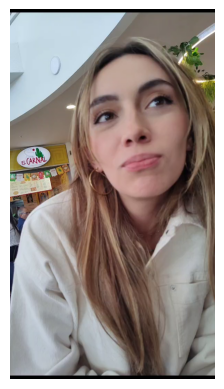

In [15]:
""" This function displays a frame of the video given the time in seconds. """
def display_frames(video_path : Path, time : float) -> None:
    clip = VideoFileClip(str(video_path))
    frame = clip.get_frame(time)
    plt.imshow(frame)
    plt.axis("off")
    clip.close()

display_frames(available_vids(PATH_VIDS)[2], 5)

In [ ]:
""" This function creates and saves a subclip of the video, given a time range. """
def sub_clip(video_path : Path, start_time : float, end_time : float) -> None:
    
    clip = VideoFileClip(str(video_path))
    if end_time > clip.duration:
        end_time = clip.duration
    if start_time < 0 or start_time > clip.duration:
        start_time = 0
    
    print(f'Start time: {start_time}, End time: {end_time}')
    if start_time >= end_time:
        raise ValueError("Start time must be less than end time.")
    
    sub = clip.subclip(start_time, end_time)
    sub.write_videofile("subclip.mp4")
    clip.close()
    sub.close()
    
# sub_clip(available_vids(PATH_CONVERTED)[2], 10, 20)

Moviepy - Building video subclip.mp4.
MoviePy - Writing audio in subclipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video subclip.mp4



Moviepy - Done !
Moviepy - video ready subclip.mp4


---
# Normalization

In [16]:
""" This function returns a list of normalized clips. """
def load_and_normalize_vids(folder : Path, resolution : tuple) -> list:
    norm_clips = []
    target_width, target_height = resolution
    
    for vid in available_vids(folder):
        clip = VideoFileClip(str(vid))
        norm = clip.resize(newsize=(target_width, target_height))
        norm_clips.append(norm)
        
    print(f'Normalized clips: {len(norm_clips)}')
    print(f'Duration: {[c.duration for c in norm_clips]}')
        
    return norm_clips

# NOTE: Clips remained open so they can be used in other functions. They should be closed later in the up coming functions. 

norm_clips = load_and_normalize_vids(PATH_CONVERTED, TARGET_RESOLUTION)

Normalized clips: 14
Duration: [20.84, 7.27, 23.73, 3.85, 13.97, 4.65, 22.7, 31.74, 11.9, 5.85, 18.11, 21.08, 4.41, 16.68]


---
# Concatenation - Level 0 (hard coded)

In [64]:
""" This function selects the clips that will be concatenated. Cut the long ones, drop the short ones, so the total duration does not exceed the given limit."""
def selected_by_duration(clips : list, max_total_length = MAX_TOTAL_LENGTH, 
                                       min_clip_length = MIN_CLIP_LENGTH, 
                                       max_clip_length = MAX_CLIP_LENGTH) -> list:
    selected = []
    total = 0.0
    
    for clip in clips:
        duration = clip.duration
        
        # Drop short clips:
        if duration < min_clip_length:
            continue
        
        # if it's too long, cut it:
        if duration > max_clip_length:
            cutted = clip.subclip(0, max_clip_length)
            duration = max_clip_length
        else:
            cutted = clip
        
        # If adding a clip exceeds the max total length, cut it:
        if total + duration > max_total_length:
            remaining = max_total_length - total
            
            # If the remaining part is not too short, cut this last video and add it:
            if remaining >= min_clip_length: 
                partial = clip.subclip(0, remaining)
                selected.append(partial)
                total += duration
            break
        else:
            selected.append(cutted)
            total += duration
    print(f'Selected clips: {len(selected)}')
    print(f'Total Duration: {total:.2f} seconds')
    return selected

selected_clips = selected_by_duration(norm_clips)
            

Selected clips: 8
Total Duration: 65.77 seconds


In [17]:
""" This function concatenates the selected clips and exports the resulting video to a given path. """
def concat_and_export(clips : list, export_path : Path, fps=30) -> None:
    try:
        if len(clips) == 0:
            raise ValueError("No clips selected.")
        
        final_clip = concatenate_videoclips(clips, method="compose")
        final_clip.write_videofile(str(export_path), 
                                fps=fps, 
                                codec="libx264", 
                                audio_codec="aac")
        final_clip.close()
    
    # Here is where the previously opened clips are closed, no matter if an error occurs or not:
    finally:   
        for c in clips:
            c.close()
            
# concat_and_export(selected_clips, PATH_OUTPUT / "concatenated.mp4", fps=30)

In [ ]:
""" This function wraps up the previous functions into one, to get the final result. """
def build_travel_summary(video_folder : Path,
                         export_path : Path,
                         target_resolution = TARGET_RESOLUTION,
                         max_total_length = MAX_TOTAL_LENGTH,
                         min_clip_length = MIN_CLIP_LENGTH,
                         max_clip_length = MAX_CLIP_LENGTH,
                         fps = 30) -> None:
    
    video_paths = available_vids(video_folder)
    if not video_paths:
        raise ValueError("No videos found in the given folder.")
    
    clips = load_and_normalize_vids(video_folder, target_resolution)
    selected = selected_by_duration(clips, max_total_length, min_clip_length, max_clip_length)
    
    concat_and_export(selected, export_path, fps)
    
# build_travel_summary(PATH_CONVERTED, PATH_OUTPUT / "summary.mp4")

Normalized clips: 14
Duration: [20.84, 7.27, 23.73, 3.85, 13.97, 4.65, 22.7, 31.74, 11.9, 5.85, 18.11, 21.08, 4.41, 16.68]
Selected clips: 8
Total Duration: 65.77 seconds
Moviepy - Building video ..\data\Output\summary.mp4.
MoviePy - Writing audio in summaryTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ..\data\Output\summary.mp4



Moviepy - Done !
Moviepy - video ready ..\data\Output\summary.mp4


---
# Concatenation - Level 1 (smart)

#### No trained models yet, just using videos information:
- Movement (difference between frames)
- Audio energy (noice, activity)

score = α · movimiento + β · energía_audio

In [18]:
def split_in_segments(clip: VideoFileClip, 
                      segment_length: float = 5.0) -> list[tuple[float, float]]:
    """Devuelve una lista de (t_start, t_end) para segmentos de duración fija."""
    segments = []
    t = 0.0
    while t < clip.duration:
        t_end = min(t + segment_length, clip.duration)
        # si el último segmento es muy chiquito, lo ignoramos
        if t_end - t >= 1.0:
            segments.append((t, t_end))
        t = t_end
    return segments

In [19]:
def motion_score_for_segment(clip: VideoFileClip, 
                             t_start: float, 
                             t_end: float, 
                             n_samples: int = 5) -> float:
    """
    Calcula un score de movimiento aproximado.
    Toma 'n_samples' frames entre t_start y t_end y mide cuánto cambian.
    """
    times = np.linspace(t_start, t_end, n_samples)
    prev_frame = None
    diffs = []
    for t in times:
        frame = clip.get_frame(t)  # shape (h, w, 3)
        gray = frame.mean(axis=2)  # pasamos a escala de grises promedio simple
        if prev_frame is not None:
            diff = np.mean(np.abs(gray - prev_frame))
            diffs.append(diff)
        prev_frame = gray
    if not diffs:
        return 0.0
    return float(np.mean(diffs))

In [ ]:
def audio_energy_for_segment(clip: VideoFileClip, t_start: float, t_end: float) -> float:
    """
    Estima la energía del audio (RMS) en ese intervalo.
    Usa muestreo explícito en el tiempo para evitar el bug interno
    de MoviePy con iter_chunks.
    """
    if clip.audio is None:
        return 0.0

    try:
        audio_subclip = clip.audio.subclip(t_start, t_end)
        duration = audio_subclip.duration or (t_end - t_start)
        if duration <= 0:
            return 0.0
        
        # margen pequeño para no muestrear exactamente en el borde
        eps = 1e-3
        effective_duration = max(0.0, duration - eps)
        if effective_duration <= 0:
            return 0.0

        # Elegimos un número moderado de muestras (p.ej. 100 por segmento)
        num_samples = min(1000, int(duration * 1000))  # tope por seguridad
        if num_samples <= 0:
            return 0.0

        times = np.linspace(0, duration, num_samples, endpoint=False)

        # Forzamos a to_soundarray a muestrear en tiempos específicos,
        # evitando el uso de iter_chunks
        arr = audio_subclip.to_soundarray(tt=times, fps=22050)

        # Convertimos a mono si es estéreo
        if arr.ndim == 2:
            arr_mono = arr.mean(axis=1)
        else:
            arr_mono = arr

        rms = float(np.sqrt(np.mean(arr_mono ** 2)))
        return rms

    except Exception as e:
        print(f"[WARN] Error calculando energía de audio ({t_start}-{t_end}): {e}")
        return 0.0



In [35]:
def segment_score(clip: VideoFileClip, 
                  t_start: float, 
                  t_end: float,
                  w_motion: float = 0.3, 
                  w_audio: float = 0.7) -> float:
    
    m = motion_score_for_segment(clip, t_start, t_end)
    a = audio_energy_for_segment(clip, t_start, t_end)
    # podrías normalizar, pero de entrada probemos así
    return w_motion * m + w_audio * a


In [ ]:
@dataclass
class Segment:
    clip: VideoFileClip
    t_start: float
    t_end: float
    score: float
    clip_index: int # For debugging, tracks which clip this segment comes from.


In [ ]:
def extract_best_segment_per_clip(clips: list[VideoFileClip], 
                                  segment_length: float = 3.0) -> list[Segment]:
    """
    Para cada clip, divide en segmentos de duración fija y se queda SOLO
    con el segmento de mayor score. Devuelve una lista con a lo sumo un
    Segment por clip.
    """
    best_segments: list[Segment] = []

    for idx, clip in enumerate(clips):
        seg_times = split_in_segments(clip, segment_length)
        print(f"\nClip #{idx} - length {clip.duration:.2f}s, segments: {len(seg_times)}")

        best_seg = None
        best_score = float("-inf")

        for (ts, te) in seg_times:
            s = segment_score(clip, ts, te)
            print(f"  segment {ts:.2f}–{te:.2f}  score={s:.4f}")
            if s > best_score:
                best_score = s
                best_seg = Segment(
                    clip=clip,
                    t_start=ts,
                    t_end=te,
                    score=s,
                    clip_index=idx
                )

        if best_seg is not None:
            print(f"=> Best clip segment #{idx}: {best_seg.t_start:.2f}–{best_seg.t_end:.2f} (score={best_seg.score:.4f})")
            best_segments.append(best_seg)

    return best_segments

In [43]:
def arrange_best_segments(segments: list[Segment],
                         max_total_duration: float = 60.0, 
                         min_segment_duration: float = 1.5) -> list[VideoFileClip]:
    """
    Recibe una lista de Segment donde ya hay como máximo uno por clip.
    Toma los segmentos en el orden dado (por defecto el de los videos)
    hasta alcanzar max_total_duration.
    """
    selected_clips: list[VideoFileClip] = []
    total = 0.0

    for seg in segments:
        dur = seg.t_end - seg.t_start
        if dur < min_segment_duration:
            continue

        if total + dur > max_total_duration:
            remaining = max_total_duration - total
            if remaining >= min_segment_duration:
                sub = seg.clip.subclip(seg.t_start, seg.t_start + remaining)
                selected_clips.append(sub)
                total += remaining
            break
        else:
            sub = seg.clip.subclip(seg.t_start, seg.t_end)
            selected_clips.append(sub)
            total += dur

    print (f'Selected clips: {len(selected_clips)}')
    print(f"Total length (smart): {total:.2f} s")
    return selected_clips


In [44]:
def build_travel_summary_smart(video_dir: Path,
                               output_path: Path, 
                               target_resolution=(720, 1280), 
                               segment_length: float = 6.0 , 
                               max_total_duration: float = 75.0,
                               fps: int = 30) -> None:
    
    video_paths = available_vids(video_dir)
    if not video_paths:
        raise ValueError(f"No videos found in {video_dir}")
    
    clips = load_and_normalize_vids(video_dir, target_resolution)
    
    segments = extract_best_segment_per_clip(clips, segment_length=segment_length)
    selected_clips = arrange_best_segments(
        segments,
        max_total_duration=max_total_duration
    )

    concat_and_export(selected_clips, output_path, fps=fps)

In [47]:
build_travel_summary_smart(PATH_CONVERTED, PATH_OUTPUT / "summary_smart.mp4")

Normalized clips: 14
Duration: [20.84, 7.27, 23.73, 3.85, 13.97, 4.65, 22.7, 31.74, 11.9, 5.85, 18.11, 21.08, 4.41, 16.68]

Clip #0 - duración 20.84s, segmentos: 4
  segmento 0.00–6.00  score=14.4827
  segmento 6.00–12.00  score=14.0829
  segmento 12.00–18.00  score=15.5942
  segmento 18.00–20.84  score=10.9930
=> Mejor segmento clip #0: 12.00–18.00 (score=15.5942)

Clip #1 - duración 7.27s, segmentos: 2
[WARN] Error calculando energía de audio (0.0-6.0): index -164335 is out of bounds for axis 0 with size 156178
  segmento 0.00–6.00  score=6.2370
  segmento 6.00–7.27  score=3.6198
=> Mejor segmento clip #1: 0.00–6.00 (score=6.2370)

Clip #2 - duración 23.73s, segmentos: 4
  segmento 0.00–6.00  score=12.7228
  segmento 6.00–12.00  score=12.6581
  segmento 12.00–18.00  score=12.3271
[WARN] Error calculando energía de audio (18.0-23.73): index -152512 is out of bounds for axis 0 with size 99929
  segmento 18.00–23.73  score=16.2887
=> Mejor segmento clip #2: 18.00–23.73 (score=16.2887)



MoviePy - Done.
Moviepy - Writing video ..\data\Output\summary_smart.mp4



Moviepy - Done !
Moviepy - video ready ..\data\Output\summary_smart.mp4


---
# Concatenation - Level 2 (Trained Models)

- Face detection / people (OpenCV and pretrained models)
- Scene description (LLM vision)
- Classification (Landscapes, food, people, etc.)
- Audio description (LLM audio)